In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling
import statsmodels.api as sm
import pandas as pd
import os
import re
from unidecode import unidecode
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from multiprocessing import Pool, cpu_count
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
data = pd.read_csv('../data-generator/newest-data-base/full-dv-data.csv')

In [4]:
data_dv_sorted = data.sort_values(by=['Nome', 'Ano', 'Semestre', 'Período'], ascending=[True, True, True, True])
data_dv_last_occurence = data_dv_sorted.drop_duplicates(subset='Nome', keep='last')
data_dv_last_occurence.reset_index(drop=True, inplace=True)

#data = data_dv_last_occurence

In [5]:
data['Situação'].value_counts()

Situação
Regular                 35585
Trancado                 3593
Desistente               2804
Formado                  1679
Afastado                  233
Transferido               119
Mudou de Curso             52
Enade pendente             49
Matrícula sub judice        6
Falecido                    5
Expulso                     2
Jubilado                    2
Name: count, dtype: int64

In [6]:
def remove_columns(df):
    columns_to_remove = ['Campus', 'Sede', 'Nome', 'Código', 'Data de ingresso', 'Data de nascimento', 'Matriz curricular', 
                         'Município', 'Município SiSU', 'Município (SISU)', 'UF SISU', 'UF (SISU)', 'E-mail', 'Funcionamento', 'Sede']
    return df.drop(columns=[col for col in columns_to_remove if col in df.columns])

In [7]:
 df = remove_columns(data)

In [8]:
def make_valid_name(name):
    if(name =='Situação'):
      return 'situacao'
    else:
        name = unidecode(name)
        name = re.sub(r'\W+', '_', name)
        name = '_'.join(filter(None, name.lower().split('_')))
        return name

In [9]:
def rename_columns(df):
    bad_names = df.columns.tolist()
    good_names = [make_valid_name(name) for name in bad_names]
    bad_to_good_converter = dict(zip(bad_names, good_names))
    df.rename(columns=bad_to_good_converter, inplace=True)
    return df

In [10]:
df = rename_columns(df)

In [11]:
data = df[(df['situacao'] == 'Desistente') | (df['situacao'] == 'Formado') | (df['situacao'] == 'Regular') | (df['situacao'] == 'Trancado')]
data.loc[data['situacao'] == 'Formado', 'situacao'] = 'Regular'
data.loc[data['situacao'] == 'Trancado', 'situacao'] = 'Desistente'
data.loc[:, 'situacao'] = data['situacao'].replace({'Regular': 0, 'Desistente': 1})
data = data.rename(columns={'situacao': 'target'})

In [12]:
def pre_process(data,dataset_name):

    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

    #class_plot(data,dataset_name)
   
    # removendo colunas com mais de 50% de valores ausentes
    data = data.dropna(axis=1, thresh=len(data) * 0.5)
    
    columns = data.columns.tolist()

    for column in columns:
        if data[column].dtype == 'object':
            data.loc[:, column] = pd.Categorical(data[column])
            data.loc[:, column] = LabelEncoder().fit_transform(data[column])
        
        data.loc[:, column] = data[column].astype(str).str.replace(',', '.', regex=True)
        data.loc[:, column] = pd.to_numeric(data[column], errors='coerce')


    return data

In [13]:
def const_remove(data,threshold):
    constant_filter = VarianceThreshold(threshold)
    constant_filter.fit(data)
    data = data.iloc[:, constant_filter.get_support()]
    
    return data

def imputation(data):
    imputer = SimpleImputer(strategy='mean')
    df_imputed = imputer.fit_transform(data)
    data = pd.DataFrame(data=df_imputed, columns=data.columns)

    return data

In [14]:
def correlation(data,threshold):
    corr = data.corr()
    mask = (corr > threshold) | (corr < (-threshold))
    columns_to_drop = []
    for col in mask.columns:
        correlated_cols = mask.index[mask[col]].tolist()
        if len(correlated_cols) > 1:
            columns_to_drop.extend(correlated_cols[1:])
    
    data = data.drop(columns=columns_to_drop)
    return data


In [15]:
def load_models():
    model_mapping = {
        'dt': DecisionTreeClassifier(random_state=0, ccp_alpha=0.02),
        'rf': RandomForestClassifier(n_estimators=100, random_state=0),
        'neigh': KNeighborsClassifier(n_neighbors=3),
        'nb': GaussianNB()
    }
      
    return model_mapping

In [16]:
def train_test(x, y, dataset_name, algorithm, corr_threshold, const_threshold, seed):
    
    n_samples = len(y)
    n_splits = min(10, n_samples)

    model_mapping = load_models()
    results = {'Model': [], 'Accuracy': [], 'Balanced Accuracy': [],  'f1-score': [],  'recall': [],  'precision': [], 'CM - True Positive': [], 'CM - False Negative': [], 'CM - False Positive': [], 'CM - True Negative': []}

    classifier = model_mapping[algorithm]
    y = pd.to_numeric(y, errors='coerce')


    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    y_pred = cross_val_predict(classifier, x, y, cv=cv)
    classifier.fit(x, y)

    predict_df = pd.DataFrame({'True_Label': y, 'Predicted_Label': y_pred})

    if not os.path.exists('predictions'):
        os.makedirs('predictions') 
    predict_df.to_csv(f'predictions/predict-{dataset_name}-{algorithm}-{corr_threshold}-{const_threshold}-{seed}.csv', index=False)

    acc = accuracy_score(y, y_pred)
    bac = balanced_accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)  

    print(f1)
    
    cm = confusion_matrix(y, y_pred)
    
    results['Model'].append(algorithm)
    results['Accuracy'].append(acc)
    results['Balanced Accuracy'].append(bac)
    results['f1-score'].append(f1)
    results['recall'].append(recall)
    results['precision'].append(precision)

    # Verifique se a matriz de confusão tem o tamanho esperado (2x2)
    if cm.shape == (2, 2):
        results['CM - True Positive'].append(cm[0][0])
        results['CM - False Negative'].append(cm[0][1])
        results['CM - False Positive'].append(cm[1][0])
        results['CM - True Negative'].append(cm[1][1])
    else:
        results['CM - True Positive'].append(None)
        results['CM - False Negative'].append(None)
        results['CM - False Positive'].append(None)
        results['CM - True Negative'].append(None)

    features = x.columns.tolist()

    return classifier, features, cm

In [17]:
def execute(data,algorithm,corr_threshold,const_threshold,seed,execution):
 
    y = data['target']
    data = pre_process(data,"teste")

    features = data.columns.tolist()
    features.remove('target')

    x = data[features]

    data = const_remove(x,const_threshold)

    data = imputation(data)

    #removendo novamente features constantes após imputação
    data = const_remove(data,const_threshold)

    data = correlation(data,corr_threshold)

    classifier, features, cm = train_test(data,y,"teste",algorithm,corr_threshold,const_threshold,seed)

    feature_mapping = {
        'grau': 'Grau',
        'curso': 'Curso',
        'turno': 'Turno',
        'genero': 'Gênero',
        'ano_de_ingresso': 'Ano de Ingresso',
        'ano_semestre_da_situacao': 'Ano/Semestre da Situação',
        'coeficiente_de_rendimento_absoluto': 'Coeficiente de Rendimento Absoluto',
        'codigo_do_curso': 'Código do Curso',
        'forma_de_ingresso': 'Forma de Ingresso',
        'idade': 'Idade',
        'nota_enem_humanas': 'Nota ENEM (Humanas)',
        'nota_enem_liguagem': 'Nota ENEM (Linguagem)',
        'nota_enem_matematica': 'Nota ENEM (Matemática)',
        'nota_enem_natureza': 'Nota ENEM (Ciências da Natureza)',
        'nota_enem_redacao': 'Nota ENEM (Redação)',
        'nota_final_sisu': 'Nota Final SISU',
        'nr_de_entradas_em_outros_cursos_de_graduacao': 'Número de Entradas em Outros Cursos de Graduação',
        'nr_disciplinas_aprovadas': 'Número de Disciplinas Aprovadas',
        'nr_disciplinas_reprovadas_por_frequencia': 'Número de Disciplinas Reprovadas por Frequência',
        'nr_disciplinas_reprovadas_por_nota': 'Número de Disciplinas Reprovadas por Nota',
        'pais_de_nascimento': 'País de Nascimento',
        'retencao_parcial': 'Retenção Parcial',
        'retencao_total': 'Retenção Total',
        'semestre_de_ingresso': 'Semestre de Ingresso',
        'tipo_de_cota': 'Tipo de Cota',
        'total_de_semestres_cursados': 'Total de Semestres Cursados',
        'total_de_semestres_do_curso': 'Total de Semestres do Curso',
        'uf': 'UF'
    }
    
    
    importance = classifier.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importância': importance})
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    importance_df['Feature'] = importance_df['Feature'].map(feature_mapping)

    return importance_df, cm

In [18]:
seeds = [145, 278, 392, 49, 203, 411, 89, 356, 27, 489]

importance_dfs = []
cms = []

for seed in seeds:
    importance_df, cm = execute(data, 'rf', 0.8, 0.05, seed, 1)
    importance_dfs.append(importance_df)
    cms.append(cm)

all_importance_df = pd.concat(importance_dfs, ignore_index=True)

0.960210558910048
0.9620272783632983
0.9637770897832817
0.9618036724258154
0.9616487177500581
0.9618722876627402
0.9612018895686517
0.9622802261637363
0.9619527314994188
0.9613088315112043


In [19]:
average_importance_df = all_importance_df.groupby('Feature').mean().reset_index()
average_importance_df = average_importance_df.sort_values(by='Importância', ascending=False)

average_cm = np.mean(np.array(cms), axis=0)

print("Média das Importâncias:")
print(average_importance_df)

print("\nMédia da Matriz de Confusão:")
print(average_cm)

Média das Importâncias:
                             Feature  Importância
12                  Retenção Parcial     0.016083
5                              Idade     0.014671
13                    Retenção Total     0.012990
9             Nota ENEM (Matemática)     0.009246
7                Nota ENEM (Humanas)     0.009002
6   Nota ENEM (Ciências da Natureza)     0.008966
8              Nota ENEM (Linguagem)     0.008837
10               Nota ENEM (Redação)     0.007352
14                      Tipo de Cota     0.004793
0                              Curso     0.004302
1                    Código do Curso     0.004281
16                                UF     0.003124
3                               Grau     0.002421
15                             Turno     0.002335
2                  Forma de Ingresso     0.002320
4                             Gênero     0.001996
11                País de Nascimento     0.000315

Média da Matriz de Confusão:
[[36960.2   303.8]
 [  189.2  6207.8]]


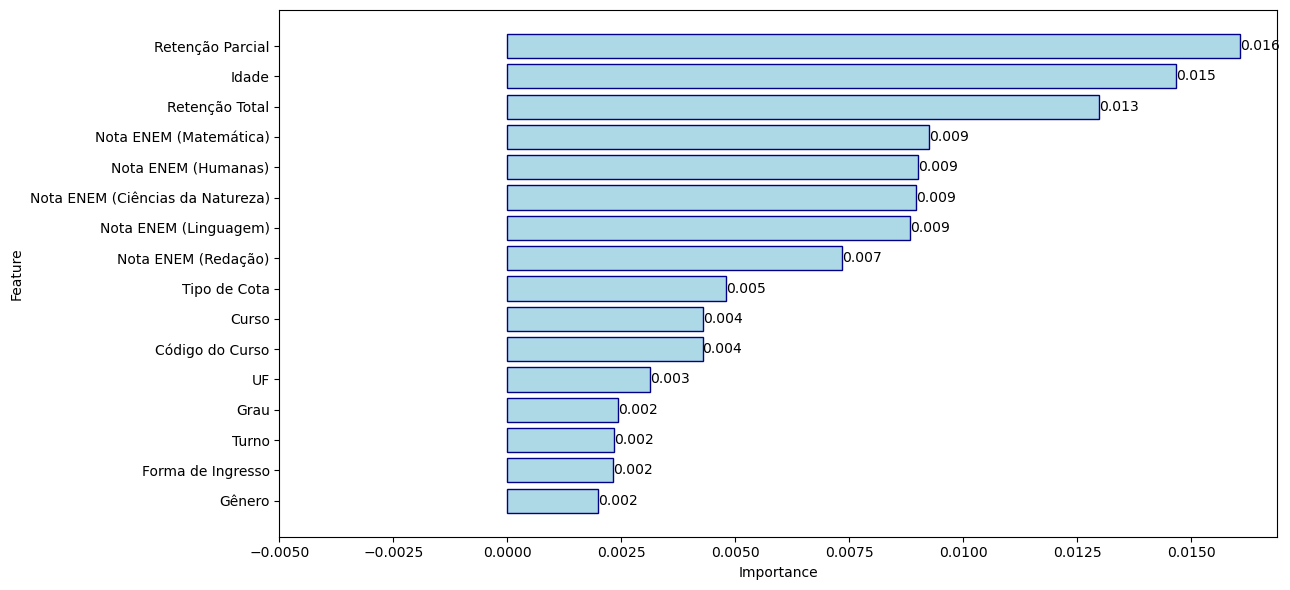

In [20]:
average_importance_df = average_importance_df[average_importance_df['Importância'] >= 0.001]

plt.figure(figsize=(13, 6))
bars = plt.barh(average_importance_df['Feature'], average_importance_df['Importância'], color='#ADD8E6', edgecolor='#00008B')  # Barra azul claro com contorno azul escuro
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  

plt.xlim(left=-0.005)  

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center')

plt.tight_layout()

#plt.savefig("feature_importance.pdf", format='pdf')


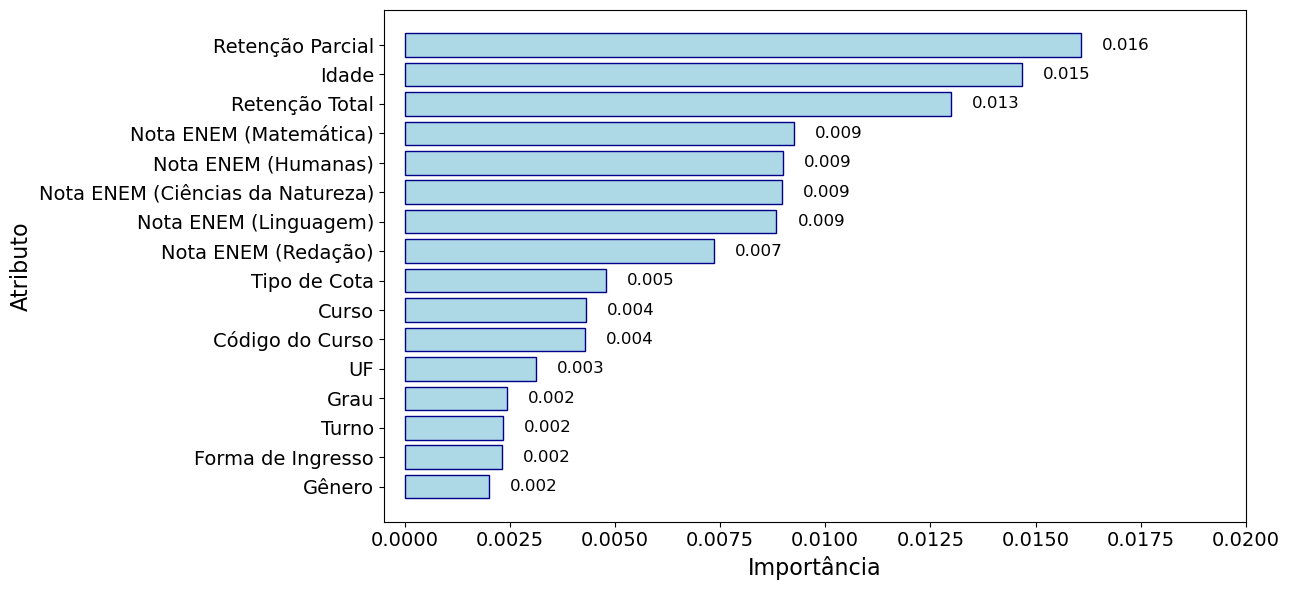

In [21]:
average_importance_df = average_importance_df[average_importance_df['Importância'] >= 0.001]

plt.figure(figsize=(13, 6))
bars = plt.barh(
    average_importance_df['Feature'], 
    average_importance_df['Importância'], 
    color='#ADD8E6', 
    edgecolor='#00008B',
)

plt.xlabel('Importância', fontsize=16)  
plt.ylabel('Atributo', fontsize=16)   
plt.gca().invert_yaxis()  

plt.xlim(left=-0.0005, right=0.02)  


for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.0005,  
        bar.get_y() + bar.get_height() / 2, 
        f'{width:.3f}', 
        va='center', 
        fontsize=12  
    )

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.tight_layout()

#plt.savefig("feature_importance_ALL_datas.pdf", format='pdf')
